In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms
import os
from PIL import Image
from IPython.display import display
device = torch.device("cuda")

In [52]:
root = '/kaggle/input/tomato'

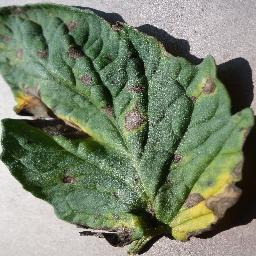

(256, 256)


In [53]:
with Image.open('/kaggle/input/tomato/valid/Early_blight/004cbe60-8ff9-4965-92df-e86694d5e9ba___RS_Erly.B 8253.JPG') as img:
    display(img)
    print(img.size)

In [54]:
root = '/kaggle/input/tomato'
img_names = []
for folder,sub_folder,filenames in os.walk(root):
    for img in filenames:
        img_names.append(folder + '/' + img)

In [55]:
len(img_names)

32534

In [56]:
img_sizes = []
rejected = []

for item in img_names:
    try : 
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)
df = pd.DataFrame(img_sizes)

In [57]:
df.describe()

,0,1
count,32534.000000,32534.000000
mean,292.992869,303.431764
std,172.509264,179.750381
min,130.000000,69.000000
25%,256.000000,256.000000
50%,256.000000,256.000000
75%,256.000000,256.000000
max,6000.000000,6000.000000


### transforms

In [58]:
train_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [59]:
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])

In [60]:
train_dataset = datasets.ImageFolder('/kaggle/input/tomato/train',transform=train_transforms)
validation_dataset = datasets.ImageFolder('/kaggle/input/tomato/valid',transform=test_transforms)

In [61]:
class_names = train_dataset.classes

In [62]:
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

In [63]:
len(class_names)

11

In [64]:
train_batch_size = 1024
test_batch_size = 1024
train_loader = DataLoader(train_dataset,train_batch_size,shuffle=True)
test_loader = DataLoader(validation_dataset,test_batch_size,shuffle=False)

In [65]:
def dim_calc(n_in,w_in,h_in,f,s,p,num_filters,max_pool,ms,mf):
    #(height,widht)
    if type(s) == tuple: #(2,1)
        s_h = s[0]
        s_w = s[1]
    else:
        s_h,s_w = s,s
    if type(f) == tuple:
        f_h = f[0]
        f_w = f[1]
    else:
        f_h,f_w = f,f
    if type(p) == tuple:
        p_h = p[0]
        p_w = p[1]
    else:
        p_h,p_w = p,p
        
    height = ((h_in-f_h+2*p_h)//s_h)+1
    width = ((w_in-f_w+2*p_w)//s_w)+1
    channels = num_filters
    if max_pool == True:
        height = ((height-mf)//ms)+1
        width = ((width-mf)//ms)+1
    return (channels,height,width)

In [66]:
print(f"1 : {dim_calc(3,256,256,3,1,0,8,True,2,2)}")
print(f"2 : {dim_calc(8, 127, 127,3,1,0,16,True,2,2)}")
print(f"3 : {dim_calc(16, 62, 62,3,1,0,32,True,2,2)}")
print(f"4 : {dim_calc(32, 30, 30,3,1,0,64,True,2,2)}")
print(f"5 : {dim_calc(64, 14, 14,3,1,0,128,True,2,2)}")

1 : (8, 127, 127)
2 : (16, 62, 62)
3 : (32, 30, 30)
4 : (64, 14, 14)
5 : (128, 6, 6)


In [67]:
128*6*6

4608

In [68]:
64*30*30

57600

In [69]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### ConvNet 1

In [70]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,stride=1,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,stride=1,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,stride=1,kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,stride=1,kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=64,out_channels=128,stride=1,kernel_size=3)
        self.fc1 = nn.Linear(128*6*6,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,32)
        self.out = nn.Linear(32,11)
        self.dropout = nn.Dropout(p=0.4)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,128*6*6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)
        return x
        

In [71]:
cnn = CNNModel().to(device)

In [72]:
cnn

CNNModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=11, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [ ]:
import time
from tqdm import tqdm
num_epochs = 20
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

start = time.time()
for epoch in range(num_epochs):
    cnn.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for img, label in pbar:
        img, label = img.to(device), label.long().to(device)
        y_pred = cnn(img)
        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/20:  62%|██████▏   | 16/26 [01:06<00:40,  4.08s/it, loss=1.0029]

In [74]:
#15 epochs
from sklearn.metrics import classification_report
all_preds = []
all_labels = []

cnn.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        pred = cnn(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       732
           1       0.67      0.68      0.67       643
           2       0.57      0.62      0.60       792
           3       0.78      0.75      0.77       739
           4       0.79      0.50      0.61       746
           5       0.78      0.89      0.83       435
           6       0.76      0.81      0.79       457
           7       0.88      0.93      0.90       498
           8       0.95      0.89      0.92       584
           9       0.95      0.89      0.92       805
          10       0.42      0.74      0.54       252

    accuracy                           0.75      6683
   macro avg       0.75      0.77      0.75      6683
weighted avg       0.77      0.75      0.76      6683



In [75]:
#20 epochs

from sklearn.metrics import classification_report
all_preds = []
all_labels = []

cnn.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        pred = cnn(img)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       732
           1       0.67      0.68      0.67       643
           2       0.57      0.62      0.60       792
           3       0.78      0.75      0.77       739
           4       0.79      0.50      0.61       746
           5       0.78      0.89      0.83       435
           6       0.76      0.81      0.79       457
           7       0.88      0.93      0.90       498
           8       0.95      0.89      0.92       584
           9       0.95      0.89      0.92       805
          10       0.42      0.74      0.54       252

    accuracy                           0.75      6683
   macro avg       0.75      0.77      0.75      6683
weighted avg       0.77      0.75      0.76      6683

